# Набор данных

**Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии**

Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

## Import библиотек

In [ ]:
import pandas as pd
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

## Загрузка данных на Google Drive

In [ ]:
uploaded = files.upload()

Saving cars_moldova_cat_num.csv to cars_moldova_cat_num.csv


## Считываем файл в DataFrame



метод .read_csv(path,delimiter)

In [ ]:
df = pd.read_csv('/content/cars_moldova_cat_num.csv', delimiter = ',')
df

Make  Model  Year  Style  Distance  Engine_capacity(cm3)  Fuel_type  \
0        40     92  2011      4  195000.0                1800.0          2   
1        32     62  2014     11  135000.0                1500.0          0   
2        32     71  2012     11  110000.0                1500.0          0   
3        28     23  2006     11  200000.0                1600.0          3   
4        23    124  2000      5  300000.0                2200.0          0   
...     ...    ...   ...    ...       ...                   ...        ...   
32069    42     88  2016     10   88000.0                1800.0          4   
32070    19     53  2002      3  225000.0                1800.0          3   
32071     6     77  2015     11   89000.0                1500.0          0   
32072    22     10  2006      1  370000.0                2000.0          0   
32073    32     62  2006      6  300000.0                1500.0          0   

       Transmission  Price(euro)       km_year  
0                 1       7750.0  17727.272727  
1                 0       8550.0  16875.000000  
2                 0       6550.0  11000.000000  
3                 0       4100.0  12500.000000  
4                 0       3490.0  13636.363636  
...             ...          ...           ...  
32069             1      11500.0  14666.666667  
32070             0       4400.0  11250.000000  
32071             0       7000.0  12714.285714  
32072             0       4000.0  23125.000000  
32073             0       4000.0  18750.000000  

[32074 rows x 10 columns]

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']


# Метод главных компонент


In [ ]:
from sklearn.decomposition import PCA

Рассмотри многомерный вариант

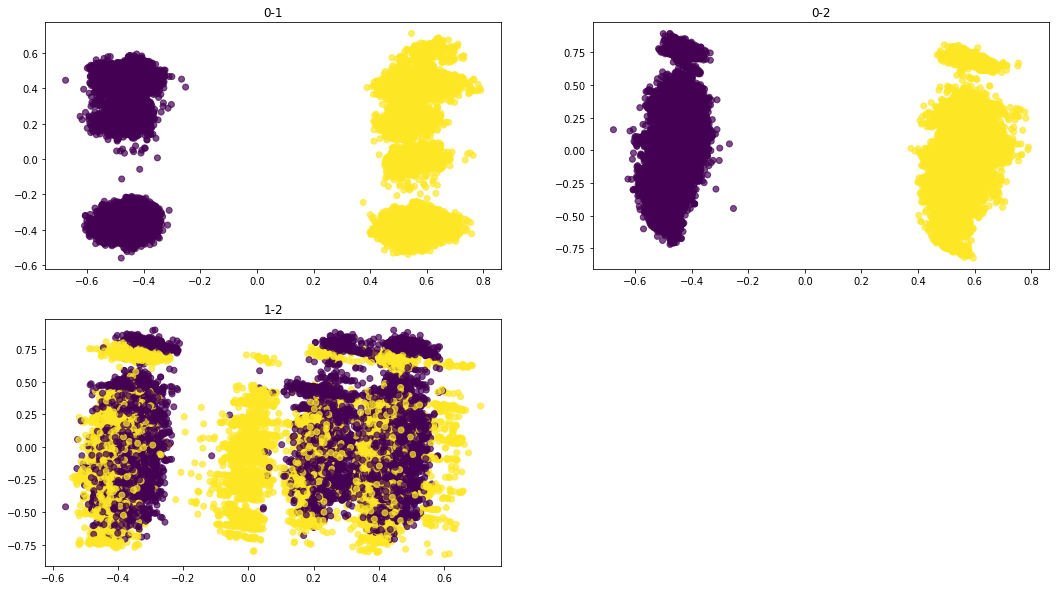

In [ ]:
scaler    = MinMaxScaler()
X = scaler.fit_transform(df)
pca = PCA()
labels = df.Transmission

X_new = pca.fit_transform(X)

pca_names = ['pca-'+str(x+1) for x in range(X_new.shape[1])]

df[pca_names] = X_new

plt.figure(figsize=(18,10))
plt.subplot(221); plt.scatter(X_new[:,0],X_new[:,1], c =labels, alpha = 0.7); plt.title("0-1")
plt.subplot(222); plt.scatter(X_new[:,0],X_new[:,2], c =labels, alpha = 0.7); plt.title("0-2")
plt.subplot(223); plt.scatter(X_new[:,1],X_new[:,2], c =labels, alpha = 0.7); plt.title("1-2")
plt.show();

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

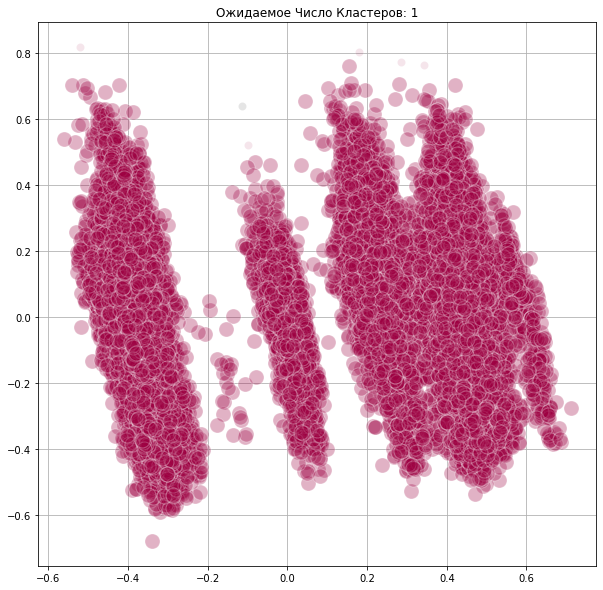

In [ ]:
#@title Кластеризация DBSCAN { run: "auto" }
#@markdown ### Выбор двух разных Главных Компонент
pca_x =  2 #@param {type:"slider", min:1, max:10, step:1}
pca_y = 6 #@param {type:"slider", min:1, max:10, step:1}
#@markdown ### epsilon
eps = 0.15 #@param {type:"slider", min:0.05, max:0.50, step:0.05}
#@markdown ### minimum sample
min_samples = 20 #@param {type:"slider", min:0, max:25, step:5}

X_cluster = df.loc[:,['pca-'+str(pca_x), 'pca-'+str(pca_y)]].values

db = DBSCAN(eps=eps, min_samples=min_samples)
db.fit(X_cluster)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10,10))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 0]

    class_member_mask = (labels == k)

    xy = X_cluster[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='w', markersize=15, alpha=0.3)

    xy = X_cluster[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='w', markersize=8, alpha=0.1)

plt.grid()
plt.title('Ожидаемое Число Кластеров: %d' % n_clusters_);

# Иерархическая Кластеризация

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from itertools import cycle

from sklearn.cluster import AgglomerativeClustering

In [ ]:
def plot_dendrogram(model,write_split, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    ddata = dendrogram(linkage_matrix, **kwargs)

    plt.title('Дендрограма')
    plt.xlabel('индес точки (размер кластера)')
    plt.ylabel('Расстояние')
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        if y > write_split:
            plt.plot(x, y, 'o', c=c)
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                          textcoords='offset points',
                          va='top', ha='center')

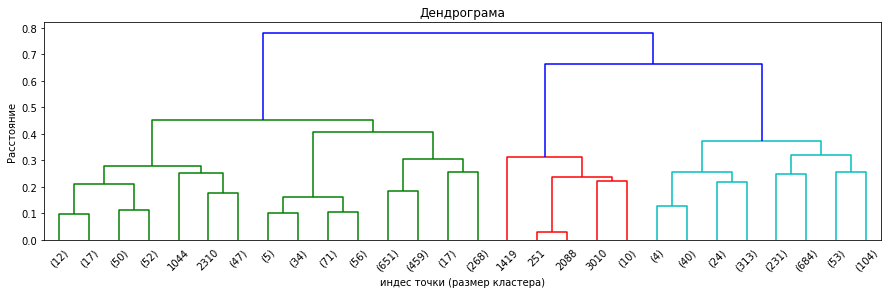

In [ ]:
#@title Иерархическая Кластеризация { run: "auto" }
#@markdown ### Выбор двух разных Главных Компонент
pca_x =  2 #@param {type:"slider", min:1, max:10, step:1}
pca_y = 6 #@param {type:"slider", min:1, max:10, step:1}
#@markdown ### Тип Связей
linkage = "average" #@param [ 'ward', 'average', 'complete', 'single']{type:"string"}


hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage)
hc.fit(X_cluster[::10])
plt.figure(figsize=(15,4))
plt.title('Дендрограма')
plot_dendrogram(hc,write_split=1, truncate_mode='level', p=4)
plt.xlabel("индес точки (размер кластера)");


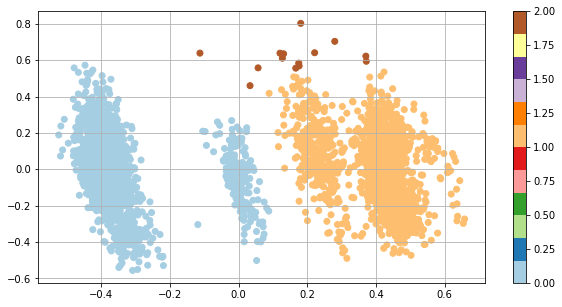

In [ ]:
#@title Выбор порога расстояния
#@markdown
dt = 0.7 #@param {type:"number"}

model = AgglomerativeClustering(distance_threshold=dt, n_clusters=None, linkage=linkage)

model = model.fit(X_cluster[::10])

labels=model.fit_predict(X_cluster[::10])


plt.figure(figsize=(10, 5))
plt.scatter(X_cluster[::10, 0], X_cluster[::10, 1], c=labels, cmap ='Paired')
plt.colorbar()
plt.grid();

# Наивная Байесовская Классификация

## Для числовых данных

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
X = df[num_columns].values
y = df["Transmission"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
#@title Числовые данные { run: "auto" }
#@markdown ### Априорные Вероятности
b1=0.6#@param {type:"slider", min:0.1, max:0.9, step:0.1}
b2=1-b1
priors = [b1 , b2] #@param [ "None", "[b1 , b2]"]{type:"raw"}


GNB = GaussianNB(priors=priors)

**Применение Метрик**

In [ ]:
GNB.fit(X_train, y_train)

y_predict=GNB.predict(X_test)

print('test error')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test,average='binary'))


print (classification_report(y_test, y_predict, target_names=['Manual','Automatic']))

test error
ACC: 0.7973
F1 : 0.7430
              precision    recall  f1-score   support

      Manual       0.76      0.92      0.83      5253
   Automatic       0.88      0.65      0.74      4370

    accuracy                           0.80      9623
   macro avg       0.82      0.78      0.79      9623
weighted avg       0.81      0.80      0.79      9623



**Кросс-валидация**

In [ ]:
scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

scores = cross_validate(GNB, X_train, y_train,
                      scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_GNB = pd.DataFrame(scores)
display(DF_cv_GNB)
print('\n')
print(DF_cv_GNB.mean()[2:])

Результаты Кросс-валидации


fit_time  score_time  test_ACC   test_F1  test_Precision  test_Recall
0  0.011220    0.014896  0.784012  0.722857        0.879694     0.613482
1  0.008681    0.014702  0.785969  0.727376        0.876282     0.621726
2  0.008901    0.014200  0.784187  0.728343        0.863123     0.629971
3  0.008734    0.014644  0.787528  0.734262        0.862565     0.639185
4  0.009304    0.014430  0.778396  0.720427        0.855808     0.622028



test_ACC          0.784019
test_F1           0.726653
test_Precision    0.867494
test_Recall       0.625279
dtype: float64


Вероятности принадлежности к классу

In [ ]:
GNB.predict_proba(X_test[0:1,:])

array([[0.95235957, 0.04764043]])

Логорифмы вероятности принадлежности к классу

In [ ]:
GNB.predict_log_proba(X_test[0:1,:])

array([[-0.04881261, -3.04407359]])

Средние значения каждого признака для каждого из классов

In [ ]:
pd.DataFrame(GNB.theta_, columns = num_columns)

Year  Distance  Engine_capacity(cm3)  Price(euro)   km_year
0  0.695072  0.394360              0.300806     0.050130  0.276968
1  0.806887  0.323552              0.401751     0.142102  0.321202

Стандартные отклонения для каждого из классов

In [ ]:
pd.DataFrame(GNB.var_, columns = num_columns)

Year  Distance  Engine_capacity(cm3)  Price(euro)   km_year
0  0.021849  0.033409              0.007530     0.001746  0.019260
1  0.012342  0.029761              0.020924     0.012584  0.022564

## Для категориальных данных

In [ ]:
from sklearn.naive_bayes import CategoricalNB

In [ ]:
X = df[cat_columns[:-1]].values
y = df["Transmission"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
#@title Категориальные данные { run: "auto" }
#@markdown ### Априорные Вероятности
b1=0.5#@param {type:"slider", min:0.1, max:0.9, step:0.1}
b2=1-b1
priors = [b1 , b2] #@param [ "None", "[b1 , b2]"]{type:"raw"}


CNB = CategoricalNB( class_prior=priors)

**Применение Метрик**

In [ ]:
CNB.fit(X_train, y_train)

y_predict=CNB.predict(X_test)

print('test error')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test,average='binary'))

print (classification_report(y_test, y_predict, target_names=['Manual','Automatic']))

test error
ACC: 0.5473
F1 : 0.6449
              precision    recall  f1-score   support

      Manual       0.76      0.25      0.38      5253
   Automatic       0.50      0.91      0.64      4370

    accuracy                           0.55      9623
   macro avg       0.63      0.58      0.51      9623
weighted avg       0.64      0.55      0.50      9623



**Кросс-валидация**

In [ ]:
scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

scores = cross_validate(GNB, X_train, y_train,
                      scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_CNB = pd.DataFrame(scores)
display(DF_cv_CNB)
print('\n')
print(DF_cv_CNB.mean()[2:])

Результаты Кросс-валидации


fit_time  score_time  test_ACC   test_F1  test_Precision  test_Recall
0  0.006516    0.009004  0.566466  0.181589        0.681388     0.104753
1  0.005302    0.009544  0.568151  0.195769        0.676218     0.114452
2  0.005439    0.009085  0.561915  0.175262        0.647059     0.101358
3  0.005349    0.008916  0.564365  0.186356        0.654971     0.108632
4  0.005465    0.008831  0.569265  0.194838        0.686217     0.113537



test_ACC          0.566033
test_F1           0.186763
test_Precision    0.669170
test_Recall       0.108546
dtype: float64


#  Регрессия Методом Опорных Векторов

In [ ]:
from sklearn.svm import SVR


**Считываем данные, разбиваем на тестовую и тренировочную, нормализуем**

Для метода опорных вектором мы возьмем не все данные, а ~1/5

In [ ]:
df_num = df[num_columns].copy()

X,y = df_num.drop(columns = ['Price(euro)']).values[::5,:],df_num['Price(euro)'].values[::5]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
#@title **Параметры Метода Опорных векторов** { run: "auto" }
#@markdown ### Margin / Зазор
epsilon=742#@param {type:"slider", min:1, max:1000, step:1}
#@markdown ### Константа регуляризации
C=75 #@param {type:"slider", min:25, max:250, step:25}

#@markdown ### Параметры Ядер
kernel = 'poly'  #@param [ 'rbf' , 'linear', 'poly']{type:"string"}
coef0=0.5 #@param {type:"slider", min:0, max:5, step:0.5}
degree=4 #@param {type:"slider", min:1, max:5, step:1}
gamma=0.95 #@param {type:"slider", min:0.00, max:1, step:0.05}

if gamma == 0:
  gamma='auto'

SVM_reg=SVR(kernel=kernel, epsilon=epsilon, C=C, gamma=gamma,
            degree=degree, coef0 = coef0)

**Применение Метрик**

In [ ]:
SVM_reg.fit(X_train, y_train)
y_predict=SVM_reg.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 37417729.1
RMSE: 6117.0
R2 : 0.5972


**Опорные Вектора**

In [ ]:
SVM_reg.support_vectors_.shape

(3350, 4)

## Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

In [ ]:
C_range = loguniform(1e-1, 1e3)
gamma_range = loguniform(1e-2, 1e0)
C_range_poly = loguniform(1e-1, 1e2)
epsilon = stats.uniform(10, 1000)
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gamma_range,
                     'C': C_range, 'epsilon': epsilon},
                    {'kernel': ['poly'], 'degree': [2,3,4,5,6], 'C': C_range_poly, 'epsilon': epsilon}]


n_iter_search = 15
SVR_search = RandomizedSearchCV(estimator = SVR(coef0=0.5), verbose = 3,
                          param_distributions=tuned_parameters ,
                          cv=ShuffleSplit(n_splits=5, random_state=42),n_iter = n_iter_search)

SVR_search.fit(X_train, y_train)

SVRbest=SVR_search.best_estimator_

SVRbest.fit(X_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END C=13.069417121586486, epsilon=289.93105219016644, gamma=0.01838860002361545, kernel=rbf;, score=-0.069 total time=   1.1s
[CV 2/5] END C=13.069417121586486, epsilon=289.93105219016644, gamma=0.01838860002361545, kernel=rbf;, score=-0.052 total time=   1.1s
[CV 3/5] END C=13.069417121586486, epsilon=289.93105219016644, gamma=0.01838860002361545, kernel=rbf;, score=-0.076 total time=   1.1s
[CV 4/5] END C=13.069417121586486, epsilon=289.93105219016644, gamma=0.01838860002361545, kernel=rbf;, score=-0.076 total time=   1.1s
[CV 5/5] END C=13.069417121586486, epsilon=289.93105219016644, gamma=0.01838860002361545, kernel=rbf;, score=-0.083 total time=   1.1s
[CV 1/5] END C=5.843447359043577, epsilon=147.15171261260573, gamma=0.010801699918166006, kernel=rbf;, score=-0.072 total time=   1.1s
[CV 2/5] END C=5.843447359043577, epsilon=147.15171261260573, gamma=0.010801699918166006, kernel=rbf;, score=-0.056 total time=  

**Лучший результат достигается:**

In [ ]:
SVRbest

SVR(C=9.64204305915292, coef0=0.5, degree=6, epsilon=835.4098889871527,
    kernel='poly')

**Опорные Вектора**

In [ ]:
SVRbest.support_vectors_.shape

(3088, 4)

**Рассмотрим результаты перебора**

In [ ]:
DF_reg=pd.DataFrame(SVR_search.cv_results_)
DF = DF_reg[['param_C','param_epsilon','param_kernel','param_degree','param_gamma',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

**Визуализация Тестовых и Предсказанных значений**

In [ ]:
def print_stem(y, label, marker):
    markerline, stemlines, baseline = plt.stem(y, markerfmt=marker,label = label,use_line_collection = True, )
    markerline.set_markerfacecolor('none')

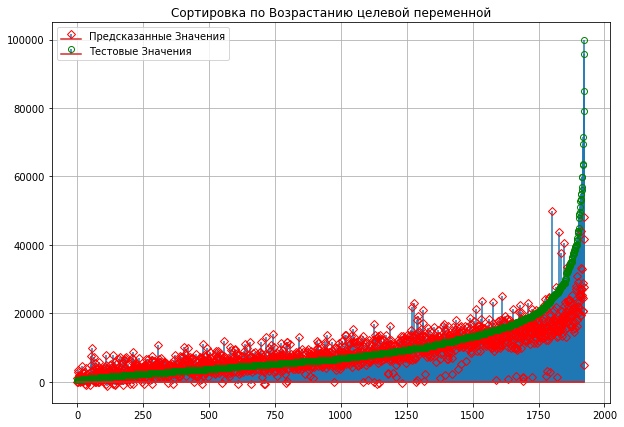

In [ ]:
fig=plt.figure(figsize=(10, 7))
sorted = np.argsort(y_test)
print_stem(y_predict[sorted], 'Предсказанные Значения', 'rD')
print_stem(y_test[sorted], 'Тестовые Значения', 'go')

plt.grid()
plt.title('Сортировка по Возрастанию целевой переменной')
plt.legend();

# Классификация Методом Опорных Векторов

In [ ]:
from sklearn.svm import SVC


**Считываем данные, разбиваем на тестовую и тренировочную, нормализуем**

Для метода опорных векторов мы возьмем не все данные, а ~1/5

In [ ]:
X = df[num_columns].values[::5,:]
y = df["Transmission"].values[::5]
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
X_train.shape, X_test.shape

((4490, 5), (1925, 5))

In [ ]:
#@title **Параметры Метода Опорных векторов** { run: "auto" }
#@markdown ### Константа регуляризации
C=75 #@param {type:"slider", min:25, max:250, step:25}

#@markdown ### Параметры Ядер
kernel = 'rbf'  #@param [ 'rbf' , 'linear', 'poly']{type:"string"}
coef0=0.5 #@param {type:"slider", min:0, max:5, step:0.5}
degree=5 #@param {type:"slider", min:1, max:5, step:1}
gamma=0.95 #@param {type:"slider", min:0.00, max:1, step:0.05}

if gamma == 0:
  gamma='auto'

SVM_clf=SVC(kernel=kernel, C=C, gamma=gamma,
            degree=degree, coef0 = coef0)

In [ ]:
SVM_clf.fit(X_train, y_train)
y_predict=SVM_clf.predict(X_test)

print (classification_report(y_test, y_predict, target_names=['Manual','Automatic']))

              precision    recall  f1-score   support

      Manual       0.78      0.89      0.83      1034
   Automatic       0.85      0.71      0.77       891

    accuracy                           0.81      1925
   macro avg       0.82      0.80      0.80      1925
weighted avg       0.81      0.81      0.81      1925



In [ ]:
SVM_clf.support_vectors_.shape

(1957, 5)

## Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска

In [ ]:
C_range = loguniform(1e-2, 1e2)
gamma_range = loguniform(1e-2, 1e0)
C_range_poly = loguniform(1e-1, 1e1)
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gamma_range,
                     'C': C_range,},
                    {'kernel': ['poly'], 'degree': [2,3,4,], 'C': C_range_poly, }]


n_iter_search = 15
SVС_search = RandomizedSearchCV(estimator = SVC(coef0=0.5), verbose = 3,
                          param_distributions=tuned_parameters ,
                          cv=StratifiedKFold(n_splits=5, shuffle = True,random_state=42),n_iter = n_iter_search)

SVС_search.fit(X_train, y_train)

SVCbest=SVС_search.best_estimator_

SVCbest.fit(X_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END C=0.47136733829049426, degree=3, kernel=poly;, score=0.820 total time=   0.3s
[CV 2/5] END C=0.47136733829049426, degree=3, kernel=poly;, score=0.823 total time=   0.3s
[CV 3/5] END C=0.47136733829049426, degree=3, kernel=poly;, score=0.796 total time=   0.3s
[CV 4/5] END C=0.47136733829049426, degree=3, kernel=poly;, score=0.792 total time=   0.3s
[CV 5/5] END C=0.47136733829049426, degree=3, kernel=poly;, score=0.831 total time=   0.4s
[CV 1/5] END C=0.7521886823050985, degree=2, kernel=poly;, score=0.821 total time=   0.3s
[CV 2/5] END C=0.7521886823050985, degree=2, kernel=poly;, score=0.818 total time=   0.3s
[CV 3/5] END C=0.7521886823050985, degree=2, kernel=poly;, score=0.795 total time=   0.3s
[CV 4/5] END C=0.7521886823050985, degree=2, kernel=poly;, score=0.785 total time=   0.3s
[CV 5/5] END C=0.7521886823050985, degree=2, kernel=poly;, score=0.833 total time=   0.3s
[CV 1/5] END C=0.01850933376612072

In [ ]:
SVCbest

SVC(C=0.10309053695497415, coef0=0.5, degree=4, kernel='poly')

In [ ]:
SVCbest.support_vectors_.shape

(1974, 5)

In [ ]:
DF_reg=pd.DataFrame(SVС_search.cv_results_)
DF = DF_reg[['param_C','param_kernel','param_degree','param_gamma',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("seagreen", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

# Контрольные вопросы